# Parameters

In [82]:
dataset_metatada = "./networks/metadata.json"
opt = 'selected'
dvs = {
    "selected": {
        "TopologyZoo": ["Bellcanada", "Cogentco"],
        "DEFO": ["rf1239_real_hard"],
        "FatTree": ["FatTree8", "FatTree16", "FatTree32"]
    }
}
dataset_view = dvs[opt] if opt in dvs else None
save_figs = True

# Parameters
detection_delay = [
    100000,  # nanoseconds = 100 microseconds
    1000000,  # nanoseconds = 1 ms
    10000000,  # nanoseconds = 10 ms
]
cache_lookup_delay = [
    0,  # nanoseconds
]
entry_installation_delay = [
    int(1e9/10000),  # nanoseconds = 100 microseconds
    int(1e9/1000),  # nanoseconds = 1 ms
    int(1e9/100),  # nanoseconds = 10 ms
]
packet_processing_delay = [
    10,  # nanoseconds
]
parameters = {
    'detection_delay': detection_delay,
    'cache_lookup_delay': cache_lookup_delay,
    'entry_installation_delay': entry_installation_delay,
    'packet_processing_delay': packet_processing_delay,
}

# Module Imports

In [83]:
import collections
import json
import math
import random
import time

import networkx as nx
import numpy as np
import pandas as pd

In [84]:
# MATPLOTLIB AND SEABORN
import matplotlib.pylab as pylab
from matplotlib.patches import Rectangle, FancyBboxPatch
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

%matplotlib inline

pylab.rcParams['font.size'] = 24
# pylab.rcParams['figure.figsize'] = [3*x for x in [3.52, 2.64]]
pylab.rcParams['figure.figsize'] = [2.5*x for x in [4.40, 2.75]]
pylab.rcParams['figure.dpi'] = 100
pylab.rcParams['errorbar.capsize'] = 3
pylab.rcParams['legend.fontsize'] = 12
pylab.rcParams['lines.linewidth'] = 2

gridcolor = '#bbbbbb'

# zvalue = 1.645  # 90%
# zvalue = 1.960  # 95%
zvalue = 2.576  # 99%

# Processing Functions

In [85]:
def hstr(num):
    if num / 1e9 >= 1:
        return f"{num/1e9:.0f}s"
    if num / 1e6 >= 1:
        return f"{num/1e6:.0f}ms"
    if num / 1e3 >= 1:
        return f"{num/1e3:.0f}us"
    else:
        return f"{num:.0f}ns"

In [86]:
def main_loop(dm, params):
    datasets = dm['datasets']

    data = {}

    for dtd in params["detection_delay"]:
        hdtd = hstr(dtd)
        data[hdtd] = {}
        for cld in params["cache_lookup_delay"]:
            hcld = hstr(cld)
            data[hdtd][hcld] = {}
            for eid in params["entry_installation_delay"]:
                heid = hstr(eid)
                data[hdtd][hcld][heid] = {}
                for ppd in params["packet_processing_delay"]:
                    hppd = hstr(ppd)
                    data[hdtd][hcld][heid][hppd] = {}
                    for ds in datasets:
                        # print(f"Dataset={ds['name']}")
                        base_dir = f"./results/downtime/csvs/detection/{hdtd}/cache_lookup/{hcld}/entry_installation/{heid}/packet_processing/{hppd}/"
                        for nn in ds['networks']:
                            # print(f"  Network={nn}")
                            print(end=".")
                            ndf = pd.read_csv(f"{base_dir}/{ds['name']}-{nn}.csv", index_col=0)
                            data[hdtd][hcld][heid][hppd][nn] = ndf
    print()
    return data


# Compute Data

In [87]:
%%time

# Open full metadata
with open(dataset_metatada) as f:
    dm = json.load(f)

# Apply view
if dataset_view is not None:
    datasets = []
    for ds in dm['datasets']:
        if ds['name'] in dataset_view.keys():
            ds['networks'] = dataset_view[ds['name']]
            datasets.append(ds)
    dm['datasets'] = datasets

# Run main loop
data = main_loop(dm, parameters)

......................................................
CPU times: user 875 ms, sys: 191 ms, total: 1.07 s
Wall time: 1.07 s


In [88]:
ns = {
    'Bellcanada': 'BC',
    'Cogentco': 'CG',
    'rf1239_real_hard': 'SL',
    "FatTree8": "FT8",
    "FatTree16": "FT16",
    "FatTree32": "FT32"
}

wan_topos = ["Bellcanada", "Cogentco", "rf1239_real_hard"]
dcn_topos = ["FatTree8", "FatTree16", "FatTree32"]

all_topos = dcn_topos + wan_topos

In [89]:
hdtds = list(data.keys())
for hdtd in data.keys():
    hclds = list(data[hdtd].keys())
    for hcld in data[hdtd].keys():
        heids = list(data[hdtd][hcld].keys())
        for heid in data[hdtd][hcld].keys():
            hppds = list(data[hdtd][hcld][heid].keys())

print(f"hdtds: {hdtds}")
print(f"hclds: {hclds}")
print(f"heids: {heids}")
print(f"hppds: {hppds}")

hdtds: ['100us', '1ms', '10ms']
hclds: ['0ns']
heids: ['100us', '1ms', '10ms']
hppds: ['10ns']


# Plots

## Downtime

In [90]:
columns_dt = ["ssdn_hi", "pcsdn_hi", "felix_hi"]
collbls_dt = ["S-SDN", "PC-SDN", "Felix"]
colors_dt = [['#F87171', '#DC2626', '#991B1B'], ['#2DD4BF', '#0D9488', '#115E59'], ['#818CF8', '#4F46E5', '#3730A3']]
bar_offset = 0.9
bar_width = 0.9

tab_dt = {}
tab_dt_ci = {}

sms = "s"

for hdtd in data.keys():
    tab_dt[hdtd] = {}
    tab_dt_ci[hdtd] = {}
    for hcld in data[hdtd].keys():
        tab_dt[hdtd][hcld] = {}
        tab_dt_ci[hdtd][hcld] = {}
        for heid in data[hdtd][hcld].keys():
            tab_dt[hdtd][hcld][heid] = {}
            tab_dt_ci[hdtd][hcld][heid] = {}
            for hppd in data[hdtd][hcld][heid].keys():
                tab_dt[hdtd][hcld][heid][hppd] = pd.DataFrame(columns=columns_dt)
                tab_dt_ci[hdtd][hcld][heid][hppd] = pd.DataFrame(columns=columns_dt)
                for nn in all_topos:
                    ndf = data[hdtd][hcld][heid][hppd][nn]
                    row = []
                    row_ci = []
                    for c in columns_dt:
                        if sms == "s":
                            row.append(ndf[c].mean()/1e9)  # seconds
                            row_ci.append(zvalue*(ndf[c]/1e9).std()/math.sqrt(len(ndf[c])))  # seconds
                        elif sms == "ms":
                            row.append(ndf[c].mean()/1e6)  # milliseconds
                            row_ci.append(zvalue*(ndf[c]/1e6).std()/math.sqrt(len(ndf[c])))  # milliseconds
                    tab_dt[hdtd][hcld][heid][hppd].loc[nn] = row
                    tab_dt_ci[hdtd][hcld][heid][hppd].loc[nn] = row_ci

# display(tab_dt)

### Detection Delay

In [91]:
# dtd = variable
cld = "0ns"
# cld = "10ms"
eid = "1ms"
ppd = "10ns"

for j, dtd in enumerate(hdtds):
    print(f"Detection Delay: {dtd}")
    display(tab_dt[dtd][cld][eid][ppd])


Detection Delay: 100us


,ssdn_hi,pcsdn_hi,felix_hi
FatTree8,0.360004,0.027240,0.000248
FatTree16,1.235166,0.117420,0.000259
FatTree32,22.630961,0.489527,0.000267
Bellcanada,0.201527,0.028981,0.002837
Cogentco,0.568580,0.132182,0.005992
rf1239_real_hard,1.608652,0.171030,0.029588


Detection Delay: 1ms


,ssdn_hi,pcsdn_hi,felix_hi
FatTree8,0.360904,0.028140,0.001148
FatTree16,1.236066,0.118320,0.001159
FatTree32,22.631861,0.490427,0.001167
Bellcanada,0.202427,0.029881,0.003737
Cogentco,0.569480,0.133082,0.006892
rf1239_real_hard,1.609552,0.171930,0.030488


Detection Delay: 10ms


,ssdn_hi,pcsdn_hi,felix_hi
FatTree8,0.369904,0.037140,0.010148
FatTree16,1.245066,0.127320,0.010159
FatTree32,22.640861,0.499427,0.010167
Bellcanada,0.211427,0.038881,0.012737
Cogentco,0.578480,0.142082,0.015892
rf1239_real_hard,1.618552,0.180930,0.039488


#### All Topologies

# Downtime -- Detection Delay -- All Topologies


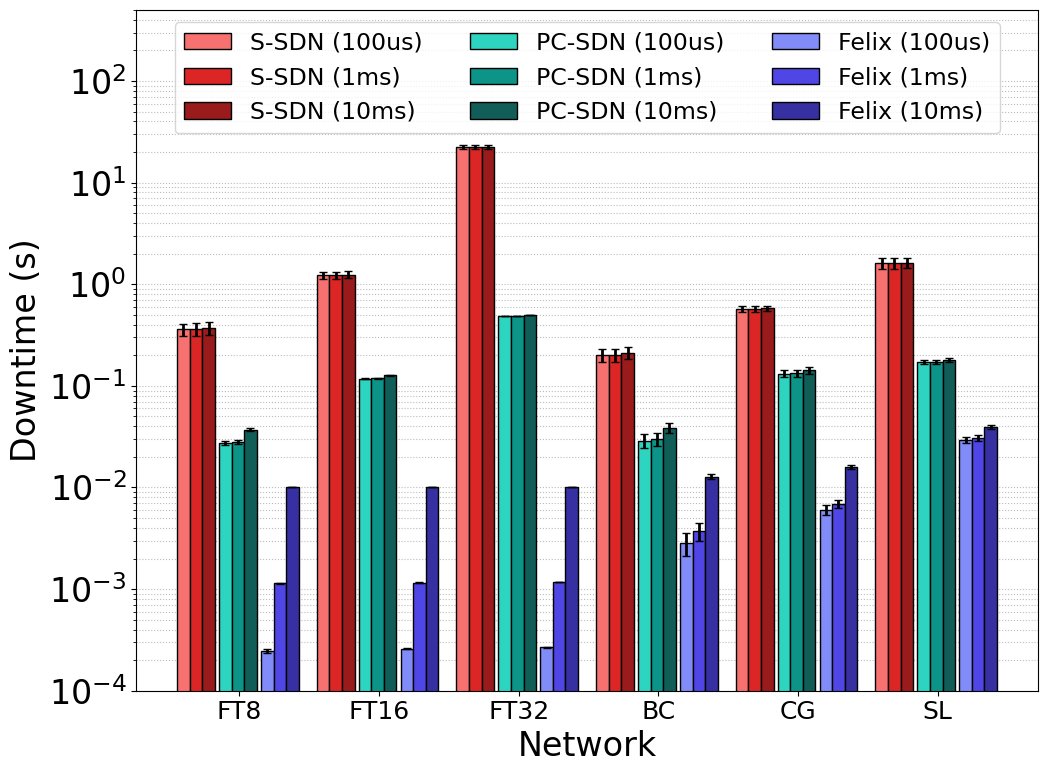

In [92]:
print("# Downtime -- Detection Delay -- All Topologies")

# dtd = variable
cld = "0ns"
# cld = "10ms"
eid = "1ms"
ppd = "10ns"

graph_topos = all_topos

fig = pylab.figure(figsize=[2.5*x for x in [4.40, 3.30]])

x = np.arange(len(graph_topos))
x = x*(len(hdtds)*len(columns_dt) + 1)

for i, c in enumerate(columns_dt):
    for j, dtd in enumerate(hdtds):
        df = tab_dt[dtd][cld][eid][ppd]
        df_ci = tab_dt_ci[dtd][cld][eid][ppd]
        pylab.bar(x + i*len(hdtds) + j*bar_offset, df.loc[graph_topos][c], yerr=df_ci.loc[graph_topos][c], width=bar_width, color=colors_dt[i][j], edgecolor="k", label=f"{collbls_dt[i]} ({dtd})")

pylab.legend(fontsize=17, ncol=3, loc="upper center", frameon=True)
pylab.xlabel('Network')
pylab.ylabel(f"Downtime ({sms})")
pylab.xticks(x + (len(hdtds)*len(columns_dt) - 1)/2, [ns[nn] for nn in graph_topos], fontsize=18)
if sms == "s":
    # pylab.ylim(10e-5, 1.5*10e2)  # seconds
    pylab.ylim(10e-5, 5*10e1)  # seconds
elif sms == "ms":
    pylab.ylim(10e-2, 1*10e4)  # milliseconds
pylab.yscale("log")

ax1 = fig.gca()
ax1.set_axisbelow(True)
ax1.grid(ls=':', axis='y', which='both', c=gridcolor)

pylab.tight_layout()
if save_figs:
    pylab.savefig(f"./results/downtime/figures/fig5-variable-detection-delay.pdf", bbox_inches='tight')
    pass


#### DCN

# Downtime -- Detection Delay -- DCN Topologies


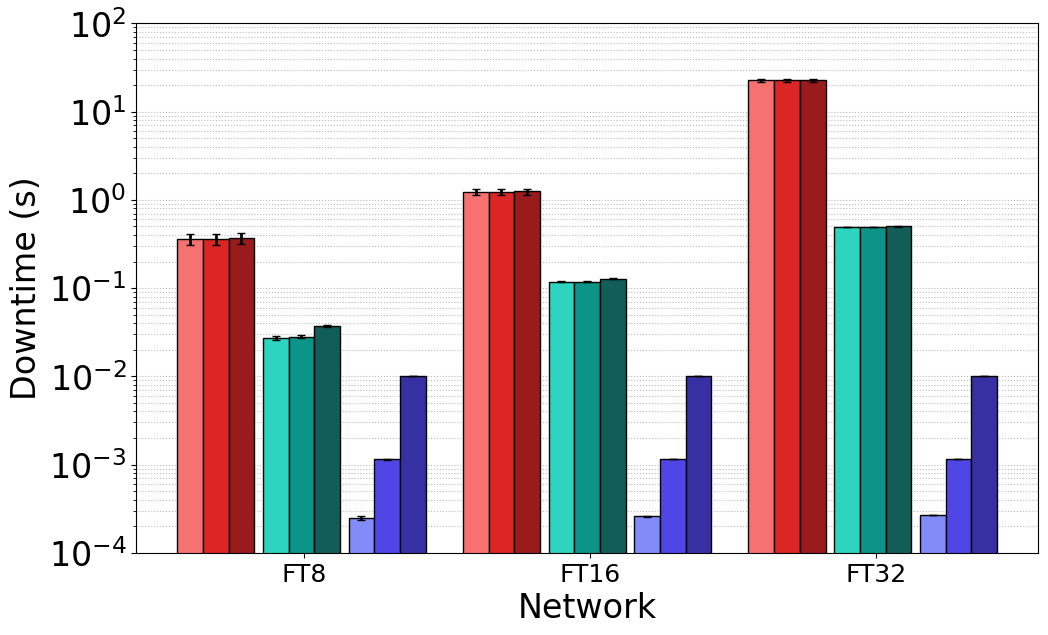

In [93]:
print("# Downtime -- Detection Delay -- DCN Topologies")

# dtd = variable
# cld = "10ms"
cld = "0ns"
eid = "1ms"
ppd = "10ns"

graph_topos = dcn_topos

fig = pylab.figure()

x = np.arange(len(graph_topos))
x = x*(len(hdtds)*len(columns_dt) + 1)

for i, c in enumerate(columns_dt):
    for j, dtd in enumerate(hdtds):
        df = tab_dt[dtd][cld][eid][ppd]
        df_ci = tab_dt_ci[dtd][cld][eid][ppd]
        pylab.bar(x + i*len(hdtds) + j*bar_offset, df.loc[graph_topos][c], yerr=df_ci.loc[graph_topos][c], width=bar_width, color=colors_dt[i][j], edgecolor="k", label=f"{collbls_dt[i]} ({dtd})")

# pylab.annotate('', xy=(26, 0.001167), xycoords='data', xytext=(26, 22.631861), textcoords='data', arrowprops={'arrowstyle': '<|-|>', 'color': 'k'})
# pylab.annotate('20,000x\nspeedup', xy=(26, 1), xycoords='data', xytext=(5, 0), textcoords='offset points', fontsize=16)

# pylab.legend(fontsize=19, ncol=2, frameon=False, loc="upper left")
pylab.xlabel('Network')
pylab.ylabel(f"Downtime ({sms})")
pylab.xticks(x + (len(hdtds)*len(columns_dt) - 1)/2, [ns[nn] for nn in graph_topos], fontsize=18)

if sms == "s":
    pylab.ylim(10e-5, 1*10e1)  # seconds
elif sms == "ms":
    pylab.ylim(10e-2, 1*10e4)  # milliseconds
pylab.yscale("log")

ax1 = fig.gca()
ax1.set_axisbelow(True)
ax1.grid(ls=':', axis='y', which='both', c=gridcolor)

pylab.tight_layout()
if save_figs:
    # pylab.savefig(f"./results/downtime/figures/raw_detectiondelay_dcntopos.pdf", bbox_inches='tight')
    pass


#### WAN

# Downtime -- Detection Delay -- WAN Topologies


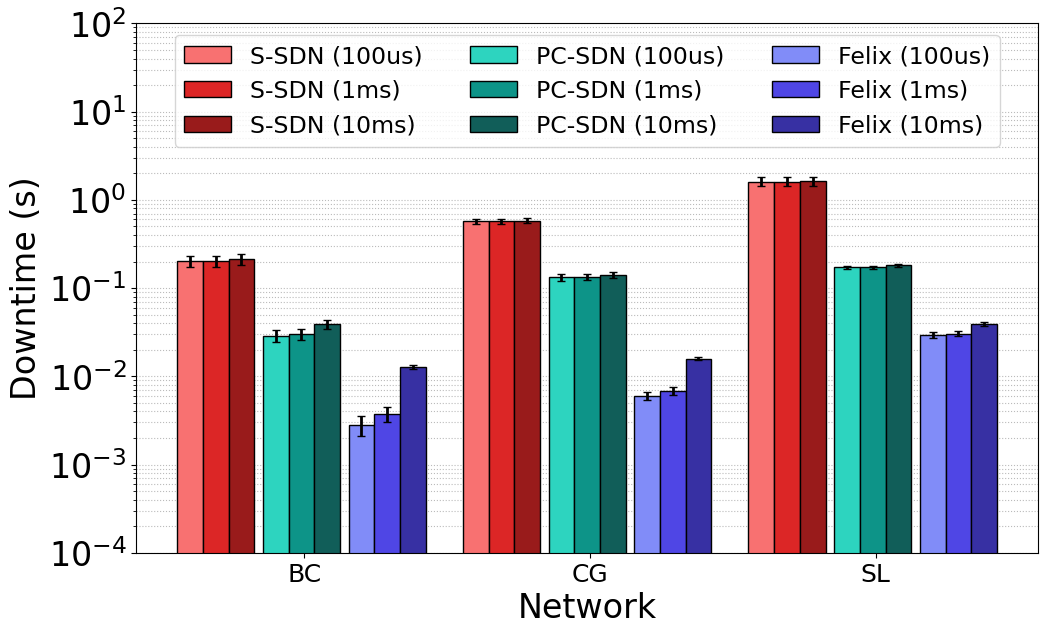

In [94]:
print("# Downtime -- Detection Delay -- WAN Topologies")

# dtd = variable
# cld = "10ms"
cld = "0ns"
eid = "1ms"
ppd = "10ns"

graph_topos = wan_topos

fig = pylab.figure()

x = np.arange(len(graph_topos))
x = x*(len(hdtds)*len(columns_dt) + 1)

for i, c in enumerate(columns_dt):
    for j, dtd in enumerate(hdtds):
        df = tab_dt[dtd][cld][eid][ppd]
        df_ci = tab_dt_ci[dtd][cld][eid][ppd]
        pylab.bar(x + i*len(hdtds) + j*bar_offset, df.loc[graph_topos][c], yerr=df_ci.loc[graph_topos][c], width=bar_width, color=colors_dt[i][j], edgecolor="k", label=f"{collbls_dt[i]} ({dtd})")

# pylab.annotate('', xy=(26, 0.001167), xycoords='data', xytext=(26, 22.631861), textcoords='data', arrowprops={'arrowstyle': '<|-|>', 'color': 'k'})
# pylab.annotate('20,000x\nspeedup', xy=(26, 1), xycoords='data', xytext=(5, 0), textcoords='offset points', fontsize=16)

pylab.legend(fontsize=17, ncol=3, loc="upper center", frameon=True)
pylab.xlabel('Network')
pylab.ylabel(f"Downtime ({sms})")
pylab.xticks(x + (len(hdtds)*len(columns_dt) - 1)/2, [ns[nn] for nn in graph_topos], fontsize=18)

if sms == "s":
    pylab.ylim(10e-5, 1*10e1)  # seconds
elif sms == "ms":
    pylab.ylim(10e-2, 1*10e4)  # milliseconds
pylab.yscale("log")

ax1 = fig.gca()
ax1.set_axisbelow(True)
ax1.grid(ls=':', axis='y', which='both', c=gridcolor)

pylab.tight_layout()
if save_figs:
    # pylab.savefig(f"./results/downtime/figures/raw_detectiondelay_wantopos.pdf", bbox_inches='tight')
    pass


### Entry Installation Delay

#### All Topologies

# Downtime -- Entry Installation Delay -- All Topologies


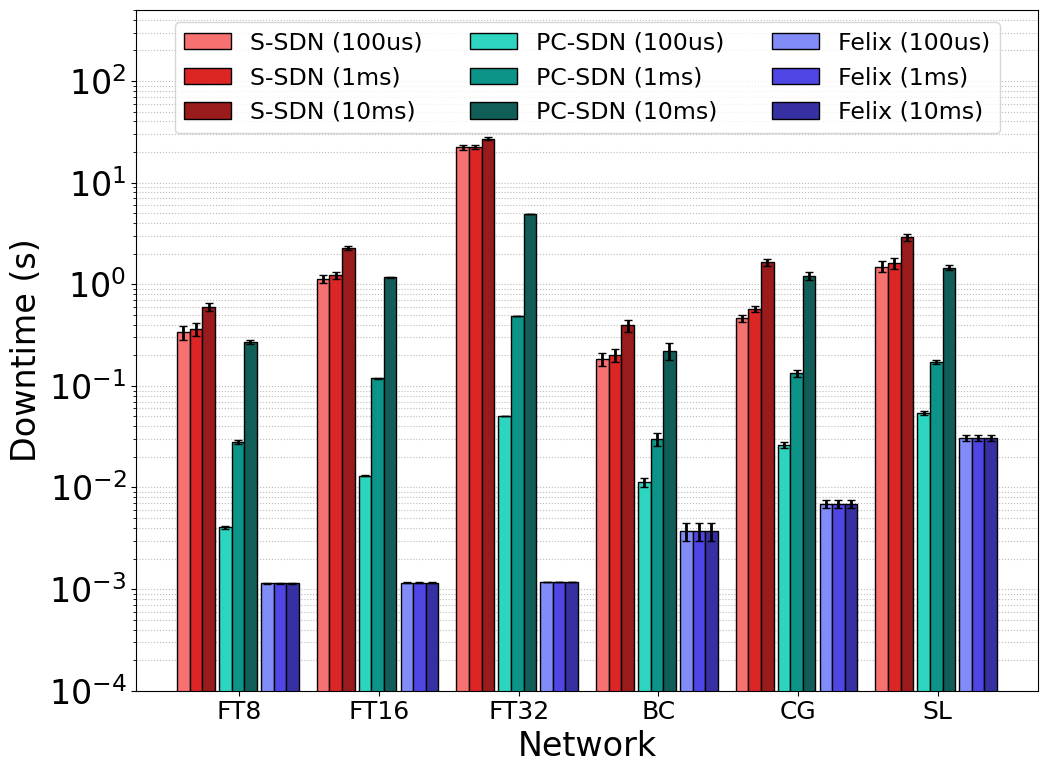

In [95]:
print("# Downtime -- Entry Installation Delay -- All Topologies")

dtd = "1ms"
# cld = "10ms"
cld = "0ns"
# eid = variable
ppd = "10ns"

graph_topos = all_topos

fig = pylab.figure(figsize=[2.5*x for x in [4.40, 3.30]])

x = np.arange(len(graph_topos))
x = x*(len(hdtds)*len(columns_dt) + 1)

for i, c in enumerate(columns_dt):
    for j, eid in enumerate(heids):
        df = tab_dt[dtd][cld][eid][ppd]
        df_ci = tab_dt_ci[dtd][cld][eid][ppd]
        pylab.bar(x + i*len(hdtds) + j*bar_offset, df.loc[graph_topos][c], yerr=df_ci.loc[graph_topos][c], width=bar_width, color=colors_dt[i][j], edgecolor="k", label=f"{collbls_dt[i]} ({eid})")

pylab.legend(fontsize=17, ncol=3, loc="upper center", frameon=True)
pylab.xlabel('Network')
pylab.ylabel(f"Downtime ({sms})")
pylab.xticks(x + (len(heids)*len(columns_dt) - 1)/2, [ns[nn] for nn in graph_topos], fontsize=18)
if sms == "s":
    # pylab.ylim(10e-5, 1.5*10e2)  # seconds
    pylab.ylim(10e-5, 5*10e1)  # seconds
elif sms == "ms":
    pylab.ylim(10e-2, 1*10e4)  # milliseconds
pylab.yscale("log")

ax1 = fig.gca()
ax1.set_axisbelow(True)
ax1.grid(ls=':', axis='y', which='both', c=gridcolor)

pylab.tight_layout()
if save_figs:
    pylab.savefig(f"./results/downtime/figures/fig6-variable-entry-installation-delay.pdf", bbox_inches='tight')
    pass


#### DCN

# Downtime -- Entry Installation Delay -- DCN Topologies


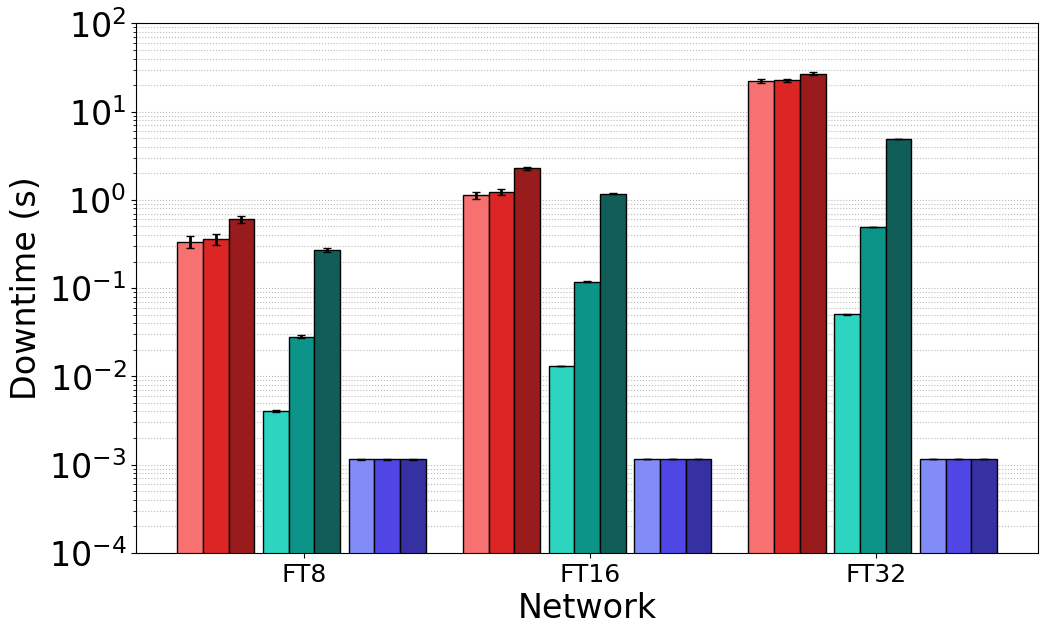

In [96]:
print("# Downtime -- Entry Installation Delay -- DCN Topologies")

dtd = "1ms"
# cld = "10ms"
cld = "0ns"
# eid = variable
ppd = "10ns"

graph_topos = dcn_topos

fig = pylab.figure()

x = np.arange(len(graph_topos))
x = x*(len(hdtds)*len(columns_dt) + 1)

for i, c in enumerate(columns_dt):
    for j, eid in enumerate(heids):
        df = tab_dt[dtd][cld][eid][ppd]
        df_ci = tab_dt_ci[dtd][cld][eid][ppd]
        pylab.bar(x + i*len(hdtds) + j*bar_offset, df.loc[graph_topos][c], yerr=df_ci.loc[graph_topos][c], width=bar_width, color=colors_dt[i][j], edgecolor="k", label=f"{collbls_dt[i]} ({eid})")

# pylab.legend(fontsize=19, ncol=2, frameon=False, loc="upper left")
pylab.xlabel('Network')
pylab.ylabel(f"Downtime ({sms})")
pylab.xticks(x + (len(heids)*len(columns_dt) - 1)/2, [ns[nn] for nn in graph_topos], fontsize=18)

if sms == "s":
    pylab.ylim(10e-5, 1*10e1)  # seconds
elif sms == "ms":
    pylab.ylim(10e-2, 1*10e4)  # milliseconds
pylab.yscale("log")

ax1 = fig.gca()
ax1.set_axisbelow(True)
ax1.grid(ls=':', axis='y', which='both', c=gridcolor)

pylab.tight_layout()
if save_figs:
    # pylab.savefig(f"./results/downtime/figures/raw_installationdelay_dcntopos.pdf", bbox_inches='tight')
    pass


#### WAN

# Downtime -- Entry Installation Delay -- WAN Topologies


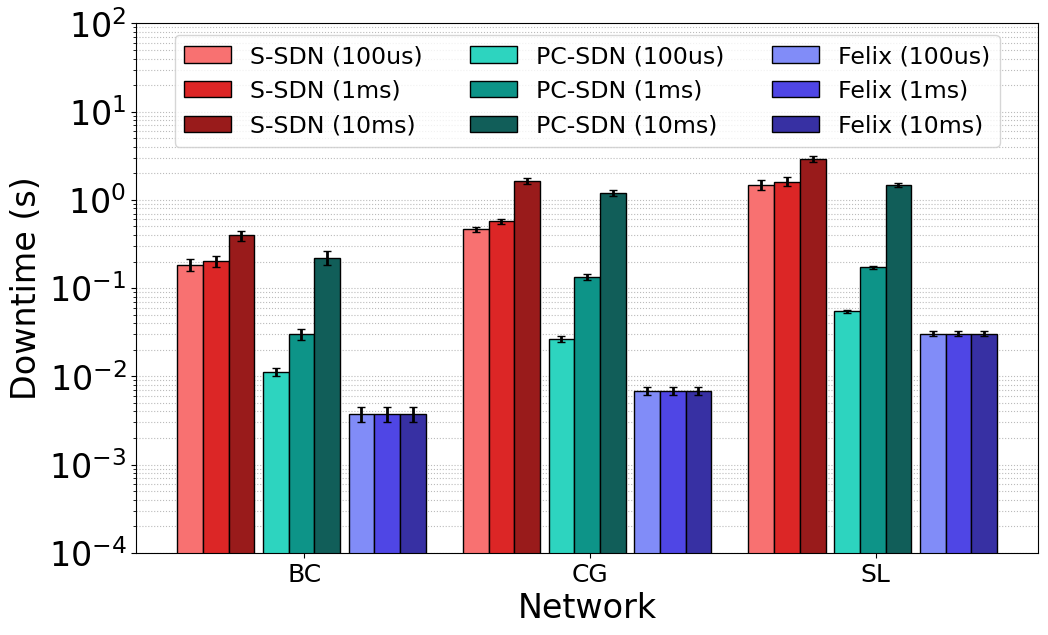

In [97]:
print("# Downtime -- Entry Installation Delay -- WAN Topologies")

dtd = "1ms"
# cld = "10ms"
cld = "0ns"
# eid = variable
ppd = "10ns"

graph_topos = wan_topos

fig = pylab.figure()

x = np.arange(len(graph_topos))
x = x*(len(hdtds)*len(columns_dt) + 1)

for i, c in enumerate(columns_dt):
    for j, eid in enumerate(heids):
        df = tab_dt[dtd][cld][eid][ppd]
        df_ci = tab_dt_ci[dtd][cld][eid][ppd]
        pylab.bar(x + i*len(hdtds) + j*bar_offset, df.loc[graph_topos][c], yerr=df_ci.loc[graph_topos][c], width=bar_width, color=colors_dt[i][j], edgecolor="k", label=f"{collbls_dt[i]} ({eid})")

# pylab.legend(fontsize=18, ncol=3, loc="upper center", frameon=False)
pylab.legend(fontsize=17, ncol=3, loc="upper center", frameon=True)
pylab.xlabel('Network')
pylab.ylabel(f"Downtime ({sms})")
pylab.xticks(x + (len(heids)*len(columns_dt) - 1)/2, [ns[nn] for nn in graph_topos], fontsize=18)

if sms == "s":
    pylab.ylim(10e-5, 1*10e1)  # seconds
elif sms == "ms":
    pylab.ylim(10e-2, 1*10e4)  # milliseconds
pylab.yscale("log")

ax1 = fig.gca()
ax1.set_axisbelow(True)
ax1.grid(ls=':', axis='y', which='both', c=gridcolor)

pylab.tight_layout()
if save_figs:
    # pylab.savefig(f"./results/downtime/figures/raw_installationdelay_wantopos.pdf", bbox_inches='tight')
    pass


## Downtime Speedup

In [98]:
columns_su = ["ssdn", "pcsdn"]
collbls_su = ["S-SDN", "PC-SDN"]
colors_su = [['#F87171', '#DC2626', '#991B1B'], ['#2DD4BF', '#0D9488', '#115E59']]
bar_offset = 0.9
bar_width = 0.9

tab_su = {}
tab_su_ci = {}

lohi = "hi"

for hdtd in data.keys():
    tab_su[hdtd] = {}
    tab_su_ci[hdtd] = {}
    for hcld in data[hdtd].keys():
        tab_su[hdtd][hcld] = {}
        tab_su_ci[hdtd][hcld] = {}
        for heid in data[hdtd][hcld].keys():
            tab_su[hdtd][hcld][heid] = {}
            tab_su_ci[hdtd][hcld][heid] = {}
            for hppd in data[hdtd][hcld][heid].keys():
                tab_su[hdtd][hcld][heid][hppd] = pd.DataFrame(columns=columns_su)
                tab_su_ci[hdtd][hcld][heid][hppd] = pd.DataFrame(columns=columns_su)
                for nn in all_topos:
                    ndf = data[hdtd][hcld][heid][hppd][nn]
                    # Felix speedup over S-SDN
                    ssdn = (ndf[f"ssdn_{lohi}"]/ndf[f"felix_{lohi}"]).mean()
                    ssdn_ci = zvalue*(ndf[f"ssdn_{lohi}"]/ndf[f"felix_{lohi}"]).std()/math.sqrt(len(ndf))
                    # Felix speedup over PC-SDN
                    pcsdn = (ndf[f"pcsdn_{lohi}"]/ndf[f"felix_{lohi}"]).mean()
                    pcsdn_ci = zvalue*(ndf[f"pcsdn_{lohi}"]/ndf[f"felix_{lohi}"]).std()/math.sqrt(len(ndf))

                    tab_su[hdtd][hcld][heid][hppd].loc[nn] = [ssdn, pcsdn]
                    tab_su_ci[hdtd][hcld][heid][hppd].loc[nn] = [ssdn_ci, pcsdn_ci]

# display(tab_su)

### Detection Delay

In [99]:
# dtd = variable
# cld = "10ms"
cld = "0ns"
eid = "1ms"
ppd = "10ns"

for j, dtd in enumerate(hdtds):
    print(f"detection delay: {dtd}")
    display(tab_su[dtd][cld][eid][ppd])

detection delay: 100us


,ssdn,pcsdn
FatTree8,2103.062318,114.467623
FatTree16,7158.107865,478.455302
FatTree32,134277.686912,1960.445046
Bellcanada,641.996543,56.490045
Cogentco,1021.444920,90.542808
rf1239_real_hard,4036.037149,97.358358


detection delay: 1ms


,ssdn,pcsdn
FatTree8,326.411770,24.253501
FatTree16,1116.481026,101.537027
FatTree32,20525.012754,419.986436
Bellcanada,98.720085,11.913310
Cogentco,182.348805,30.448466
rf1239_real_hard,461.494635,17.910075


detection delay: 10ms


,ssdn,pcsdn
FatTree8,36.577468,3.655272
FatTree16,123.105275,12.520232
FatTree32,2239.677183,49.097983
Bellcanada,17.089074,3.061971
Cogentco,39.321787,9.115826
rf1239_real_hard,73.532835,5.986584


#### All Topologies

# Speedup -- Detection Delay -- All Topologies


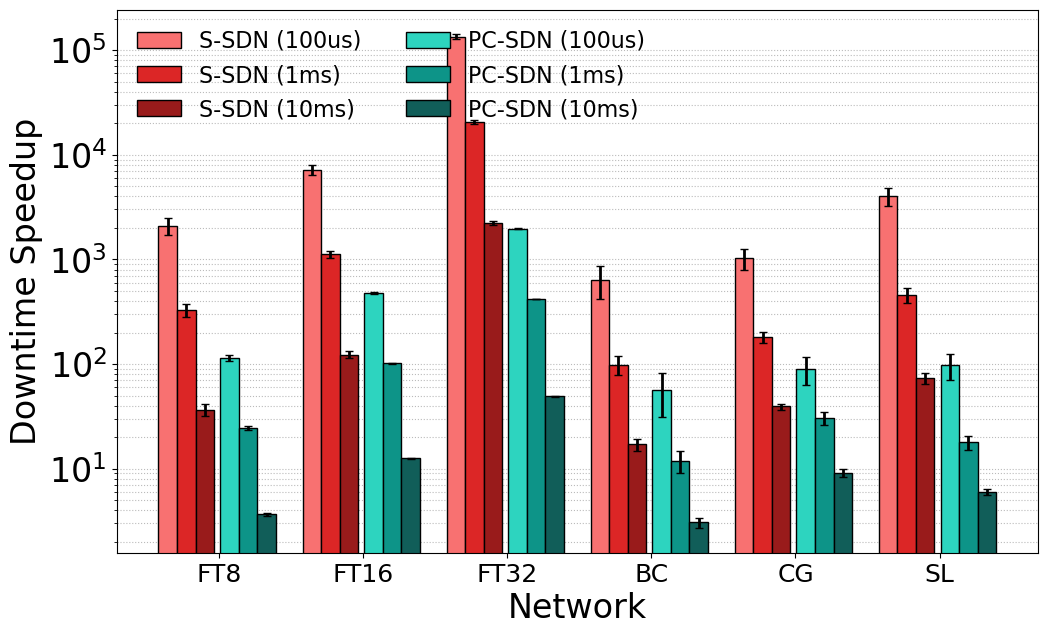

In [100]:
print("# Speedup -- Detection Delay -- All Topologies")

# dtd = variable
# cld = "10ms"
cld = "0ns"
eid = "1ms"
ppd = "10ns"

graph_topos = all_topos

fig = pylab.figure()

x = np.arange(len(graph_topos))
x = x*(len(hdtds)*len(columns_su) + 1)

for i, c in enumerate(columns_su):
    for j, dtd in enumerate(hdtds):
        df = tab_su[dtd][cld][eid][ppd]
        df_ci = tab_su_ci[dtd][cld][eid][ppd]
        pylab.bar(x + i*len(hdtds) + j*bar_offset, df.loc[graph_topos][c], yerr=df_ci.loc[graph_topos][c], width=bar_width, color=colors_su[i][j], edgecolor="k", label=f"{collbls_su[i]} ({dtd})")

pylab.legend(fontsize=16, ncol=2, loc="upper left", frameon=False)
pylab.xlabel('Network')
pylab.ylabel(f"Downtime Speedup")
pylab.xticks(x + (len(hdtds)*len(columns_su) - 1)/2, [ns[nn] for nn in graph_topos], fontsize=18)
# pylab.ylim(10e-4, 1*10e1)
pylab.yscale("log")

ax1 = fig.gca()
ax1.set_axisbelow(True)
ax1.grid(ls=':', axis='y', which='both', c=gridcolor)

pylab.tight_layout()
if save_figs:
    # pylab.savefig(f"./results/downtime/figures/speedup_detectiondelay_alltopos.pdf", bbox_inches='tight')
    pass


#### DCN

# Speedup -- Detection Delay -- DCN Topologies


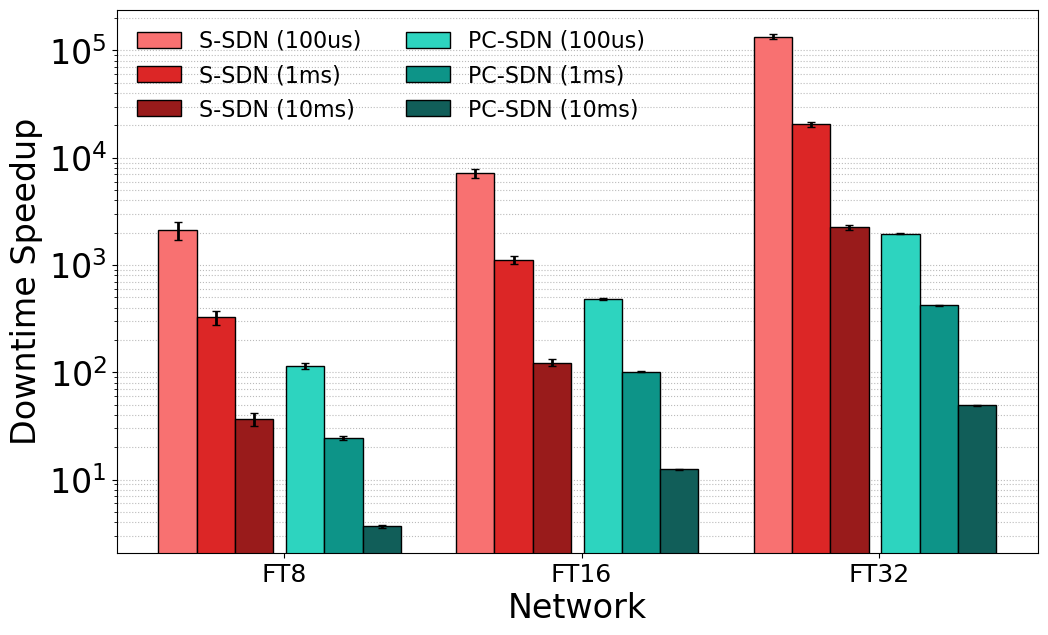

In [101]:
print("# Speedup -- Detection Delay -- DCN Topologies")

# dtd = variable
# cld = "10ms"
cld = "0ns"
eid = "1ms"
ppd = "10ns"

graph_topos = dcn_topos

fig = pylab.figure()

x = np.arange(len(graph_topos))
x = x*(len(hdtds)*len(columns_su) + 1)

for i, c in enumerate(columns_su):
    for j, dtd in enumerate(hdtds):
        df = tab_su[dtd][cld][eid][ppd]
        df_ci = tab_su_ci[dtd][cld][eid][ppd]
        pylab.bar(x + i*len(hdtds) + j*bar_offset, df.loc[graph_topos][c], yerr=df_ci.loc[graph_topos][c], width=bar_width, color=colors_su[i][j], edgecolor="k", label=f"{collbls_su[i]} ({dtd})")

pylab.legend(fontsize=16, ncol=2, loc="upper left", frameon=False)
pylab.xlabel('Network')
pylab.ylabel(f"Downtime Speedup")
pylab.xticks(x + (len(hdtds)*len(columns_su) - 1)/2, [ns[nn] for nn in graph_topos], fontsize=18)
# pylab.ylim(1, 1*10e2)
pylab.yscale("log")

ax1 = fig.gca()
ax1.set_axisbelow(True)
ax1.grid(ls=':', axis='y', which='both', c=gridcolor)

pylab.tight_layout()
if save_figs:
    # pylab.savefig(f"./results/downtime/figures/speedup_detectiondelay_dcntopos.pdf", bbox_inches='tight')
    pass


#### WAN

# Speedup -- Detection Delay -- WAN Topologies


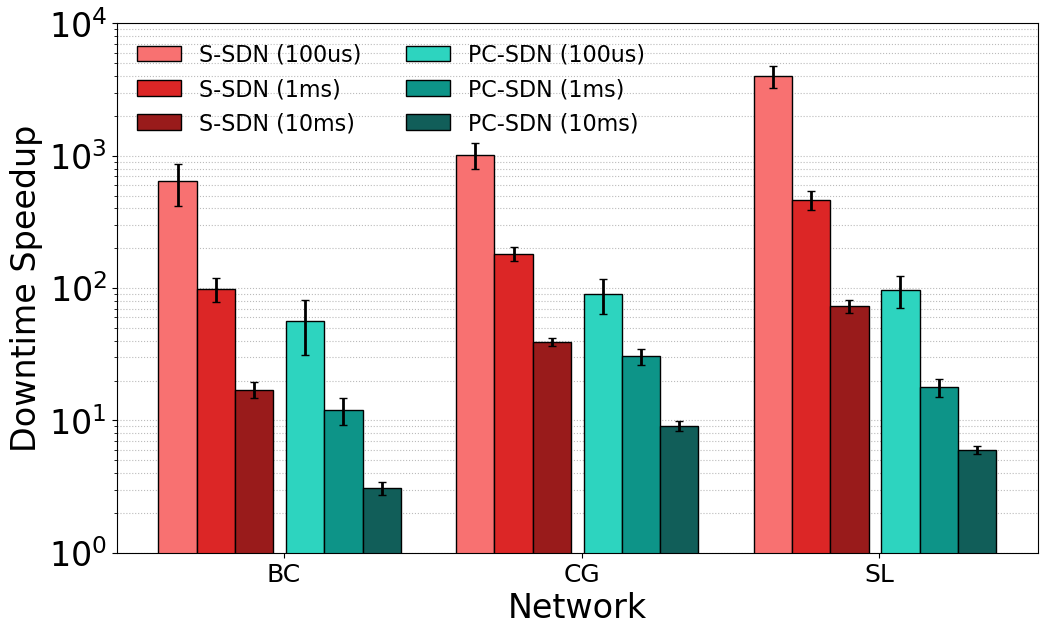

In [102]:
print("# Speedup -- Detection Delay -- WAN Topologies")

# dtd = variable
# cld = "10ms"
cld = "0ns"
eid = "1ms"
ppd = "10ns"

graph_topos = wan_topos

fig = pylab.figure()

x = np.arange(len(graph_topos))
x = x*(len(hdtds)*len(columns_su) + 1)

for i, c in enumerate(columns_su):
    for j, dtd in enumerate(hdtds):
        df = tab_su[dtd][cld][eid][ppd]
        df_ci = tab_su_ci[dtd][cld][eid][ppd]
        pylab.bar(x + i*len(hdtds) + j*bar_offset, df.loc[graph_topos][c], yerr=df_ci.loc[graph_topos][c], width=bar_width, color=colors_su[i][j], edgecolor="k", label=f"{collbls_su[i]} ({dtd})")

pylab.legend(fontsize=16, ncol=2, loc="upper left", frameon=False)
pylab.xlabel('Network')
pylab.ylabel(f"Downtime Speedup")
pylab.xticks(x + (len(hdtds)*len(columns_su) - 1)/2, [ns[nn] for nn in graph_topos], fontsize=18)
pylab.ylim(1, 1*10e3)
pylab.yscale("log")

ax1 = fig.gca()
ax1.set_axisbelow(True)
ax1.grid(ls=':', axis='y', which='both', c=gridcolor)

pylab.tight_layout()
if save_figs:
    # pylab.savefig(f"./results/downtime/figures/speedup_detectiondelay_wantopos.pdf", bbox_inches='tight')
    pass


### Entry Installation Delay

In [103]:
dtd = "10ms"
# cld = "10ms"
cld = "0ns"
# eid = variable
ppd = "10ns"

for j, eid in enumerate(heids):
    print(f"entry installation delay: {eid}")
    display(tab_su[dtd][cld][eid][ppd])

entry installation delay: 100us


,ssdn,pcsdn
FatTree8,34.208256,1.286060
FatTree16,112.758517,2.173474
FatTree32,2196.410851,5.831651
Bellcanada,15.664114,1.637011
Cogentco,32.570218,2.364258
rf1239_real_hard,69.679360,2.133110


entry installation delay: 1ms


,ssdn,pcsdn
FatTree8,36.577468,3.655272
FatTree16,123.105275,12.520232
FatTree32,2239.677183,49.097983
Bellcanada,17.089074,3.061971
Cogentco,39.321787,9.115826
rf1239_real_hard,73.532835,5.986584


entry installation delay: 10ms


,ssdn,pcsdn
FatTree8,60.269586,27.347390
FatTree16,226.572857,115.987814
FatTree32,2672.340503,481.761303
Bellcanada,31.692620,17.665517
Cogentco,107.043790,76.837830
rf1239_real_hard,113.762809,46.216559


#### All Topologies

# Speedup -- Entry Installation Delay -- All Topologies


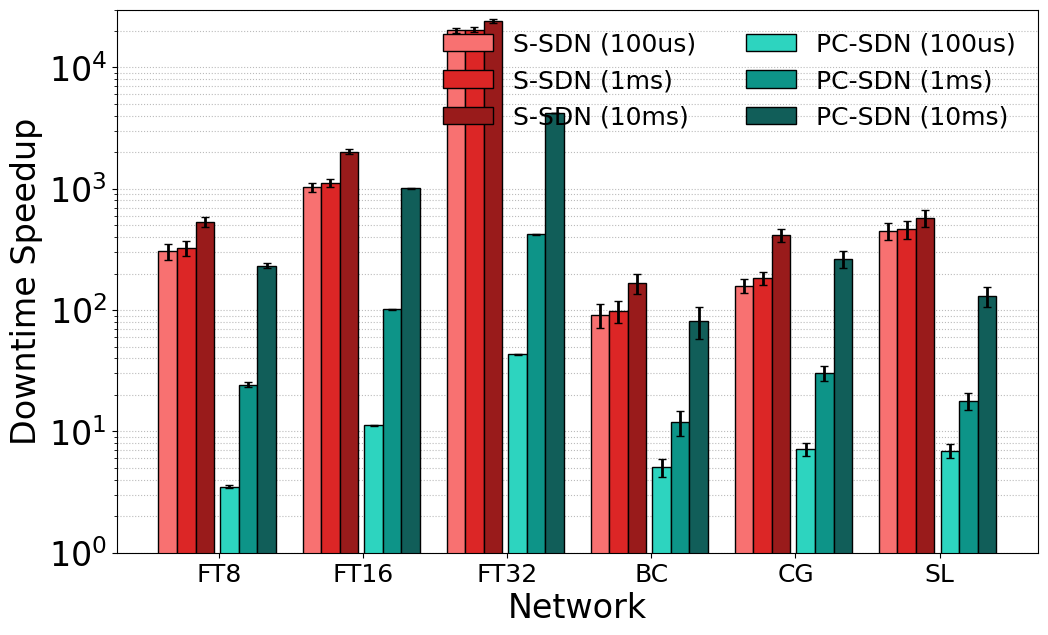

In [104]:
print("# Speedup -- Entry Installation Delay -- All Topologies")

dtd = "1ms"
# cld = "10ms"
cld = "0ns"
# eid = variable
ppd = "10ns"

graph_topos = all_topos

fig = pylab.figure()

x = np.arange(len(graph_topos))
x = x*(len(hdtds)*len(columns_su) + 1)

for i, c in enumerate(columns_su):
    for j, eid in enumerate(heids):
        df = tab_su[dtd][cld][eid][ppd]
        df_ci = tab_su_ci[dtd][cld][eid][ppd]
        pylab.bar(x + i*len(hdtds) + j*bar_offset, df.loc[graph_topos][c], yerr=df_ci.loc[graph_topos][c], width=bar_width, color=colors_su[i][j], edgecolor="k", label=f"{collbls_su[i]} ({eid})")

pylab.legend(fontsize=18, ncol=2, frameon=False)  #, loc="lower left")
pylab.xlabel('Network')
pylab.ylabel(f"Downtime Speedup")
pylab.xticks(x + (len(heids)*len(columns_su) - 1)/2, [ns[nn] for nn in graph_topos], fontsize=18)
pylab.ylim(1, 3*10e3)
pylab.yscale("log")

ax1 = fig.gca()
ax1.set_axisbelow(True)
ax1.grid(ls=':', axis='y', which='both', c=gridcolor)

pylab.tight_layout()
if save_figs:
    # pylab.savefig(f"./results/downtime/figures/speedup_installationdelay_alltopos.pdf", bbox_inches='tight')
    pass


#### DCN

# Speedup -- Entry Installation Delay -- DCN Topologies


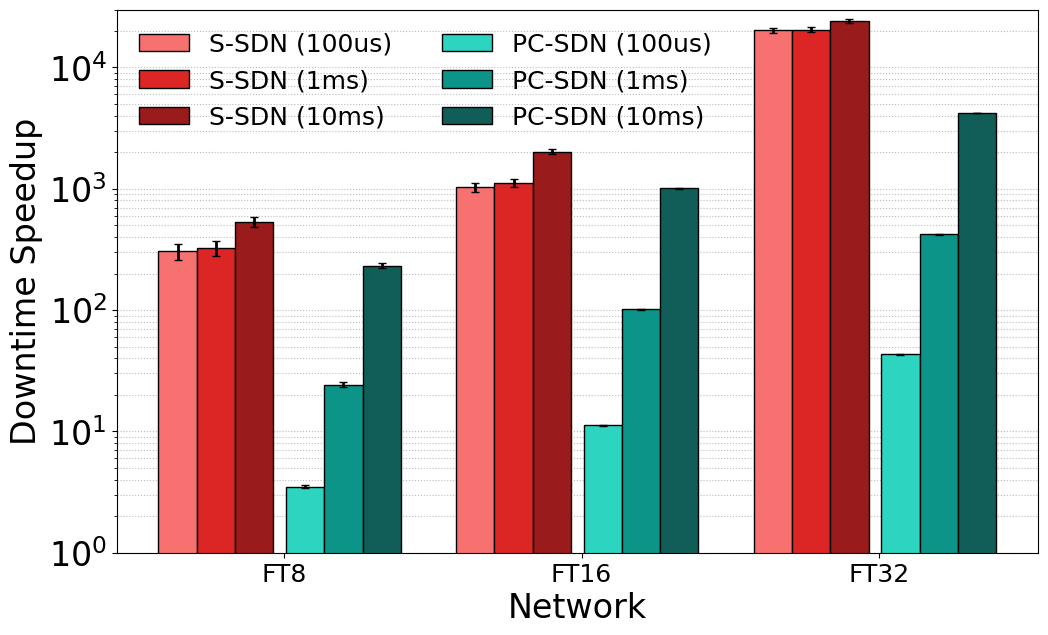

In [105]:
print("# Speedup -- Entry Installation Delay -- DCN Topologies")

dtd = "1ms"
# cld = "10ms"
cld = "0ns"
# eid = variable
ppd = "10ns"

graph_topos = dcn_topos

fig = pylab.figure()

x = np.arange(len(graph_topos))
x = x*(len(hdtds)*len(columns_su) + 1)

for i, c in enumerate(columns_su):
    for j, eid in enumerate(heids):
        df = tab_su[dtd][cld][eid][ppd]
        df_ci = tab_su_ci[dtd][cld][eid][ppd]
        pylab.bar(x + i*len(hdtds) + j*bar_offset, df.loc[graph_topos][c], yerr=df_ci.loc[graph_topos][c], width=bar_width, color=colors_su[i][j], edgecolor="k", label=f"{collbls_su[i]} ({eid})")

pylab.legend(fontsize=18, ncol=2, frameon=False)  #, loc="lower left")
pylab.xlabel('Network')
pylab.ylabel(f"Downtime Speedup")
pylab.xticks(x + (len(heids)*len(columns_su) - 1)/2, [ns[nn] for nn in graph_topos], fontsize=18)
pylab.ylim(1, 3*10e3)
pylab.yscale("log")

ax1 = fig.gca()
ax1.set_axisbelow(True)
ax1.grid(ls=':', axis='y', which='both', c=gridcolor)

pylab.tight_layout()
if save_figs:
    # pylab.savefig(f"./results/downtime/figures/speedup_installationdelay_dcntopos.pdf", bbox_inches='tight')
    pass


#### WAN

# Speedup -- Entry Installation Delay -- WAN Topologies


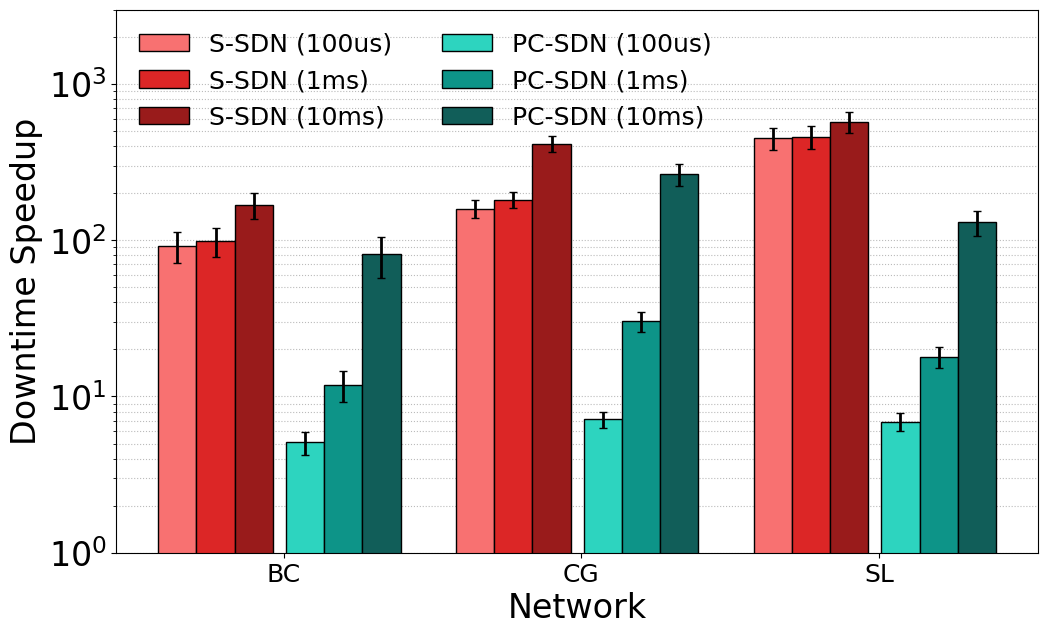

In [106]:
print("# Speedup -- Entry Installation Delay -- WAN Topologies")

dtd = "1ms"
# cld = "10ms"
cld = "0ns"
# eid = variable
ppd = "10ns"

graph_topos = wan_topos

fig = pylab.figure()

x = np.arange(len(graph_topos))
x = x*(len(hdtds)*len(columns_su) + 1)

for i, c in enumerate(columns_su):
    for j, eid in enumerate(heids):
        df = tab_su[dtd][cld][eid][ppd]
        df_ci = tab_su_ci[dtd][cld][eid][ppd]
        pylab.bar(x + i*len(hdtds) + j*bar_offset, df.loc[graph_topos][c], yerr=df_ci.loc[graph_topos][c], width=bar_width, color=colors_su[i][j], edgecolor="k", label=f"{collbls_su[i]} ({eid})")

pylab.legend(fontsize=18, ncol=2, frameon=False)  #, loc="lower left")
pylab.xlabel('Network')
pylab.ylabel(f"Downtime Speedup")
pylab.xticks(x + (len(heids)*len(columns_su) - 1)/2, [ns[nn] for nn in graph_topos], fontsize=18)
pylab.ylim(1, 3*10e2)
pylab.yscale("log")

ax1 = fig.gca()
ax1.set_axisbelow(True)
ax1.grid(ls=':', axis='y', which='both', c=gridcolor)

pylab.tight_layout()
if save_figs:
    # pylab.savefig(f"./results/downtime/figures/speedup_installationdelay_wantopos.pdf", bbox_inches='tight')
    pass


## Downtime Factors Cost Breakdown (Relative)

In [107]:
cmap = pylab.get_cmap("Set2")
colors_cb = cmap(1)
colors_cb = [cmap(x/7) for x in range(8)]

cmap = pylab.get_cmap("Paired")
colors_cb = cmap(1)
colors_cb = [cmap(x/11) for x in range(12)]

In [108]:
# columns_cb_ssdn = ["detection", "notification", "computation", "transference", "installation"]
columns_cb_ssdn = ["detection", "notification", "computation", "update"]
collbls_cb_ssdn = [x.title() for x in columns_cb_ssdn]
colors_cb_ssdn = ["#EF4444", "#DC2626", "#B91C1C", "#991B1B", "#7F1D1D"]

# columns_cb_pcsdn = ["detection", "notification", "computation", "transference", "installation"]
columns_cb_pcsdn = ["detection", "notification", "computation", "update"]
collbls_cb_pcsdn = [x.title() for x in columns_cb_pcsdn]
colors_cb_pcsdn  = ["", "", "", "", ""]

columns_cb_felix = ["detection", "coordination"]
collbls_cb_felix = [x.title() for x in columns_cb_felix]
colors_cb_felix = ["#6366F1", "#3730A3"]

tab_cb_ssdn = {}
tab_cb_pcsdn = {}
tab_cb_felix = {}

lohi = "hi"

for hdtd in data.keys():
    tab_cb_ssdn[hdtd] = {}
    tab_cb_pcsdn[hdtd] = {}
    tab_cb_felix[hdtd] = {}
    for hcld in data[hdtd].keys():
        tab_cb_ssdn[hdtd][hcld] = {}
        tab_cb_pcsdn[hdtd][hcld] = {}
        tab_cb_felix[hdtd][hcld] = {}
        for heid in data[hdtd][hcld].keys():
            tab_cb_ssdn[hdtd][hcld][heid] = {}
            tab_cb_pcsdn[hdtd][hcld][heid] = {}
            tab_cb_felix[hdtd][hcld][heid] = {}
            for hppd in data[hdtd][hcld][heid].keys():
                tab_cb_ssdn[hdtd][hcld][heid][hppd] = pd.DataFrame(columns=columns_cb_ssdn)
                tab_cb_pcsdn[hdtd][hcld][heid][hppd] = pd.DataFrame(columns=columns_cb_pcsdn)
                tab_cb_felix[hdtd][hcld][heid][hppd] = pd.DataFrame(columns=columns_cb_felix)
                for nn in all_topos:
                    ndf = data[hdtd][hcld][heid][hppd][nn]

                    # S-SDN
                    tmp = []
                    total_mean = ndf[f"ssdn_{lohi}"].mean()
                    for c in columns_cb_ssdn:
                        col_name = f"ssdn_{c}_{lohi}"
                        tmp.append(round(100*ndf[col_name].mean()/total_mean, 2))
                    tab_cb_ssdn[hdtd][hcld][heid][hppd].loc[nn] = tmp

                    # PC-SDN
                    tmp = []
                    total_mean = ndf[f"pcsdn_{lohi}"].mean()
                    for c in columns_cb_pcsdn:
                        col_name = f"pcsdn_{c}_{lohi}"
                        tmp.append(round(100*ndf[col_name].mean()/total_mean, 2))
                    tab_cb_pcsdn[hdtd][hcld][heid][hppd].loc[nn] = tmp

                    # Felix
                    tmp = []
                    total_mean = ndf[f"felix_{lohi}"].mean()
                    for c in columns_cb_felix:
                        col_name = f"felix_{c}_{lohi}"
                        tmp.append(round(100*ndf[col_name].mean()/total_mean, 2))
                    tab_cb_felix[hdtd][hcld][heid][hppd].loc[nn] = tmp

# display(tab_cb_ssdn)

### S-SDN

# Downtime Factors Cost Breakdown -- S-SDN


,detection,notification,computation,update
FatTree8,0.28,0.06,92.20,7.46
FatTree16,0.08,0.02,90.43,9.47
FatTree32,0.00,0.00,97.83,2.16
Bellcanada,0.49,2.02,85.24,12.25
Cogentco,0.18,1.29,76.63,21.90
rf1239_real_hard,0.06,0.91,89.32,9.71


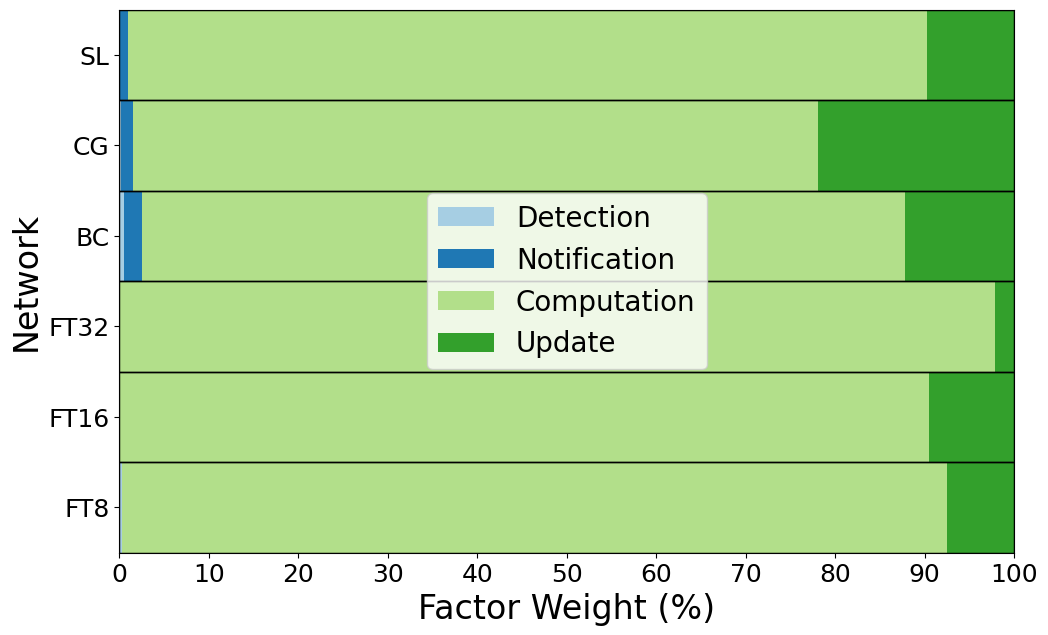

In [109]:
print("# Downtime Factors Cost Breakdown -- S-SDN")

# dtd = "100us"
dtd = "1ms"
# dtd = "10ms"
# dtd = "100ms"

# cld = "10ms"
cld = "0ns"

# eid = "100us"
eid = "1ms"
# eid = "10ms"

ppd = "10ns"

display(tab_cb_ssdn[dtd][cld][eid][ppd])

fig = pylab.figure()

baridx = np.arange(len(all_topos))

barvalsum = np.zeros(len(all_topos))
for i, c in enumerate(columns_cb_ssdn):
    barval = tab_cb_ssdn[dtd][cld][eid][ppd][c]
    pylab.barh(y=baridx, width=barval, height=1, left=barvalsum, align="center", label=collbls_cb_ssdn[i], color=colors_cb[i])
    barvalsum = barvalsum + barval
pylab.barh(baridx, width=barvalsum, height=1, align="center", edgecolor='k', color='#00000000')

pylab.legend(fontsize=20)  #, loc="lower left")
pylab.xlabel('Factor Weight (%)')
pylab.ylabel('Network')
pylab.xticks(range(0, 100 + 1, 10), fontsize=18)
pylab.yticks(baridx, [ns[x] for x in all_topos], fontsize=18)
pylab.xlim(0, 100)
pylab.ylim(-0.5, 5.5)

ax1 = fig.gca()
ax1.set_axisbelow(True)
ax1.grid(ls=':', axis='both', which='both', c=gridcolor)

pylab.tight_layout()
if save_figs:
    # pylab.savefig(f"./results/downtime/figures/breakdown_ssdn.pdf", bbox_inches='tight')
    pass

### PC-SDN

# Downtime Factors Cost Breakdown -- PC-SDN


,detection,notification,computation,update
FatTree8,3.55,0.82,0.0,95.62
FatTree16,0.85,0.20,0.0,98.95
FatTree32,0.20,0.05,0.0,99.75
Bellcanada,3.35,13.66,0.0,82.99
Cogentco,0.75,5.52,0.0,93.73
rf1239_real_hard,0.58,8.55,0.0,90.87


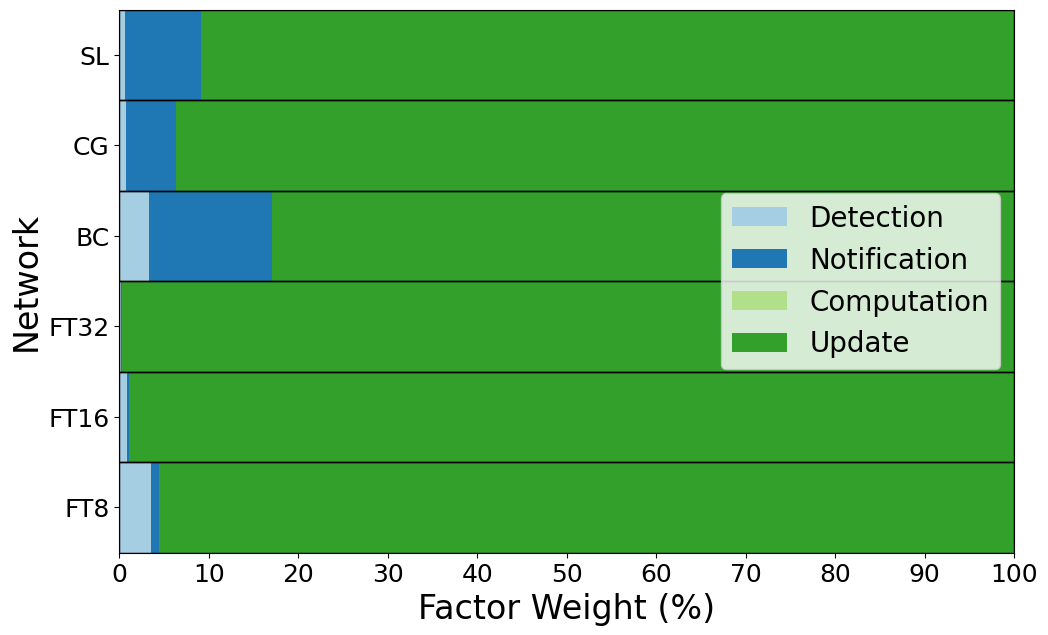

In [110]:
print("# Downtime Factors Cost Breakdown -- PC-SDN")

# dtd = "100us"
dtd = "1ms"
# dtd = "10ms"
# dtd = "100ms"

# cld = "10ms"
cld = "0ns"

# eid = "100us"
eid = "1ms"
# eid = "10ms"

ppd = "10ns"

display(tab_cb_pcsdn[dtd][cld][eid][ppd])

fig = pylab.figure()

baridx = np.arange(len(all_topos))

barvalsum = np.zeros(len(all_topos))
for i, c in enumerate(columns_cb_pcsdn):
    barval = tab_cb_pcsdn[dtd][cld][eid][ppd][c]
    pylab.barh(y=baridx, width=barval, height=1, left=barvalsum, align="center", label=collbls_cb_pcsdn[i], color=colors_cb[i])
    barvalsum = barvalsum + barval
pylab.barh(baridx, width=barvalsum, height=1, align="center", edgecolor='k', color='#00000000')

pylab.legend(fontsize=20)  #, loc="lower left")
pylab.xlabel('Factor Weight (%)')
pylab.ylabel('Network')
pylab.xticks(range(0, 100 + 1, 10), fontsize=18)
pylab.yticks(baridx, [ns[x] for x in all_topos], fontsize=18)
pylab.xlim(0, 100)
pylab.ylim(-0.5, 5.5)

ax1 = fig.gca()
ax1.set_axisbelow(True)
ax1.grid(ls=':', axis='both', which='both', c=gridcolor)

pylab.tight_layout()
if save_figs:
    # pylab.savefig(f"./results/downtime/figures/breakdown_pcsdn.pdf", bbox_inches='tight')
    pass

### Felix

# Downtime Factors Cost Breakdown -- Felix


,detection,coordination
FatTree8,87.14,12.86
FatTree16,86.25,13.75
FatTree32,85.71,14.29
Bellcanada,26.76,73.24
Cogentco,14.51,85.49
rf1239_real_hard,3.28,96.72


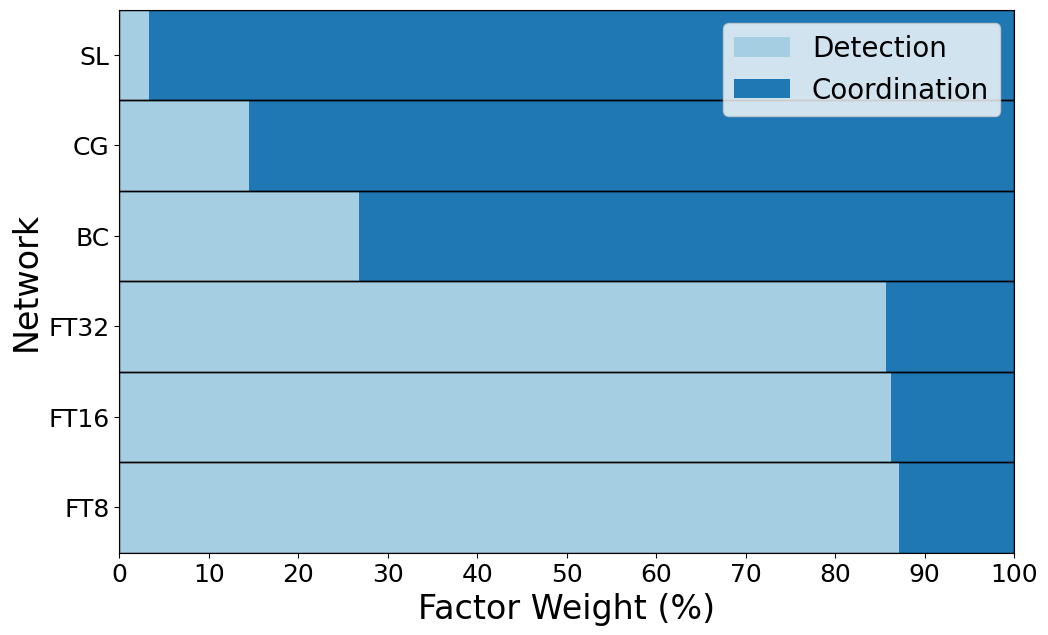

In [111]:
print("# Downtime Factors Cost Breakdown -- Felix")

# dtd = "100us"
dtd = "1ms"
# dtd = "10ms"
# dtd = "100ms"

# cld = "10ms"
cld = "0ns"

# eid = "100us"
eid = "1ms"
# eid = "10ms"

ppd = "10ns"

display(tab_cb_felix[dtd][cld][eid][ppd])

fig = pylab.figure()

baridx = np.arange(len(all_topos))

barvalsum = np.zeros(len(all_topos))
for i, c in enumerate(columns_cb_felix):
    barval = tab_cb_felix[dtd][cld][eid][ppd][c]
    pylab.barh(y=baridx, width=barval, height=1, left=barvalsum, align="center", label=collbls_cb_felix[i], color=colors_cb[i])
    barvalsum = barvalsum + barval
pylab.barh(baridx, width=barvalsum, height=1, align="center", edgecolor='k', color='#00000000')

pylab.legend(fontsize=20)  #, loc="lower left")
pylab.xlabel('Factor Weight (%)')
pylab.ylabel('Network')
pylab.xticks(range(0, 100 + 1, 10), fontsize=18)
pylab.yticks(baridx, [ns[x] for x in all_topos], fontsize=18)
pylab.xlim(0, 100)
pylab.ylim(-0.5, 5.5)

ax1 = fig.gca()
ax1.set_axisbelow(True)
ax1.grid(ls=':', axis='both', which='both', c=gridcolor)

pylab.tight_layout()
if save_figs:
    # pylab.savefig(f"./results/downtime/figures/breakdown_felix.pdf", bbox_inches='tight')
    pass

## Downtime Factors Cost Breakdown (Absolute)

In [112]:
cmap = pylab.get_cmap("Set2")
colors_cb = cmap(1)
colors_cb = [cmap(x/7) for x in range(8)]

cmap = pylab.get_cmap("Paired")
colors_cb = cmap(1)
colors_cb = [cmap(x/11) for x in range(12)]

In [113]:
columns_cb_ssdn = ["detection", "notification", "computation", "update"]
collbls_cb_ssdn = [x.title() for x in columns_cb_ssdn]
colors_cb_ssdn = ["#EF4444", "#DC2626", "#B91C1C", "#991B1B", "#7F1D1D"]

columns_cb_pcsdn = ["detection", "notification", "computation", "update"]
collbls_cb_pcsdn = [x.title() for x in columns_cb_pcsdn]
colors_cb_pcsdn  = ["", "", "", "", ""]

columns_cb_felix = ["detection", "coordination"]
collbls_cb_felix = [x.title() for x in columns_cb_felix]
colors_cb_felix = ["#6366F1", "#3730A3"]

tab_cb_ssdn = {}
tab_cb_pcsdn = {}
tab_cb_felix = {}

lohi = "hi"

for hdtd in data.keys():
    tab_cb_ssdn[hdtd] = {}
    tab_cb_pcsdn[hdtd] = {}
    tab_cb_felix[hdtd] = {}
    for hcld in data[hdtd].keys():
        tab_cb_ssdn[hdtd][hcld] = {}
        tab_cb_pcsdn[hdtd][hcld] = {}
        tab_cb_felix[hdtd][hcld] = {}
        for heid in data[hdtd][hcld].keys():
            tab_cb_ssdn[hdtd][hcld][heid] = {}
            tab_cb_pcsdn[hdtd][hcld][heid] = {}
            tab_cb_felix[hdtd][hcld][heid] = {}
            for hppd in data[hdtd][hcld][heid].keys():
                tab_cb_ssdn[hdtd][hcld][heid][hppd] = pd.DataFrame(columns=columns_cb_ssdn)
                tab_cb_pcsdn[hdtd][hcld][heid][hppd] = pd.DataFrame(columns=columns_cb_pcsdn)
                tab_cb_felix[hdtd][hcld][heid][hppd] = pd.DataFrame(columns=columns_cb_felix)
                for nn in all_topos:
                    ndf = data[hdtd][hcld][heid][hppd][nn]

                    # S-SDN
                    tmp = []
                    for c in columns_cb_ssdn:
                        col_name = f"ssdn_{c}_{lohi}"
                        if sms == "s":
                            tmp.append(round(ndf[col_name].mean()/1e9, 2))
                        elif sms == "ms":
                            tmp.append(round(ndf[col_name].mean()/1e6, 2))
                    tab_cb_ssdn[hdtd][hcld][heid][hppd].loc[nn] = tmp

                    # PC-SDN
                    tmp = []
                    for c in columns_cb_pcsdn:
                        col_name = f"pcsdn_{c}_{lohi}"
                        if sms == "s":
                            tmp.append(round(ndf[col_name].mean()/1e9, 2))
                        elif sms == "ms":
                            tmp.append(round(ndf[col_name].mean()/1e6, 2))
                    tab_cb_pcsdn[hdtd][hcld][heid][hppd].loc[nn] = tmp

                    # Felix
                    tmp = []
                    for c in columns_cb_felix:
                        col_name = f"felix_{c}_{lohi}"
                        if sms == "s":
                            tmp.append(round(ndf[col_name].mean()/1e9, 2))
                        elif sms == "ms":
                            tmp.append(round(ndf[col_name].mean()/1e6, 2))
                    tab_cb_felix[hdtd][hcld][heid][hppd].loc[nn] = tmp

# display(tab_cb_ssdn)

### S-SDN

# Downtime Factors Cost Breakdown -- S-SDN


,detection,notification,computation,update
FatTree8,0.0,0.00,0.33,0.03
FatTree16,0.0,0.00,1.12,0.12
FatTree32,0.0,0.00,22.14,0.49
Bellcanada,0.0,0.00,0.17,0.02
Cogentco,0.0,0.01,0.44,0.12
rf1239_real_hard,0.0,0.01,1.44,0.16


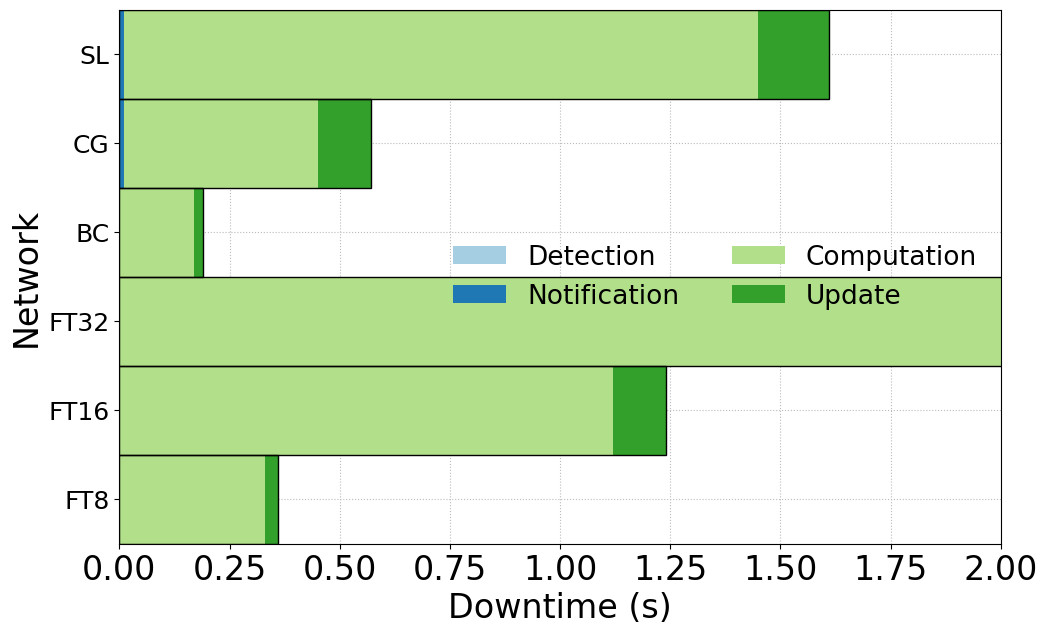

In [114]:
print("# Downtime Factors Cost Breakdown -- S-SDN")

# dtd = "100us"
dtd = "1ms"
# dtd = "10ms"
# dtd = "100ms"

# cld = "10ms"
cld = "0ns"

# eid = "100us"
eid = "1ms"
# eid = "10ms"

ppd = "10ns"

display(tab_cb_ssdn[dtd][cld][eid][ppd])

# fig = pylab.figure(figsize=[2.5*x for x in [8.80, 2.75]])
fig = pylab.figure()

baridx = np.arange(len(all_topos))

barvalsum = np.zeros(len(all_topos))
for i, c in enumerate(columns_cb_ssdn):
    barval = tab_cb_ssdn[dtd][cld][eid][ppd][c]
    pylab.barh(y=baridx, width=barval, height=1, left=barvalsum, align="center", label=collbls_cb_ssdn[i], color=colors_cb[i])
    barvalsum = barvalsum + barval
pylab.barh(baridx, width=barvalsum, height=1, align="center", edgecolor='k', color='#00000000')

# pylab.legend(fontsize=20)  #, loc="lower left")
pylab.legend(fontsize=19, ncol=2, frameon=False)  #, loc="upper left")
pylab.xlabel(f"Downtime ({sms})")
pylab.ylabel('Network')
# pylab.xticks(range(0, 100 + 1, 10), fontsize=18)
pylab.yticks(baridx, [ns[x] for x in all_topos], fontsize=18)
# pylab.xlim(0, 23)
pylab.xlim(0, 2)
# pylab.xscale("log")
pylab.ylim(-0.5, 5.5)


ax1 = fig.gca()
ax1.set_axisbelow(True)
ax1.grid(ls=':', axis='both', which='both', c=gridcolor)

pylab.tight_layout()
if save_figs:
    # pylab.savefig(f"./results/downtime/figures/ab_breakdown_ssdn.pdf", bbox_inches='tight')
    pass

### PC-SDN

# Downtime Factors Cost Breakdown -- PC-SDN


,detection,notification,computation,update
FatTree8,0.0,0.00,0.0,0.03
FatTree16,0.0,0.00,0.0,0.12
FatTree32,0.0,0.00,0.0,0.49
Bellcanada,0.0,0.00,0.0,0.02
Cogentco,0.0,0.01,0.0,0.12
rf1239_real_hard,0.0,0.01,0.0,0.16


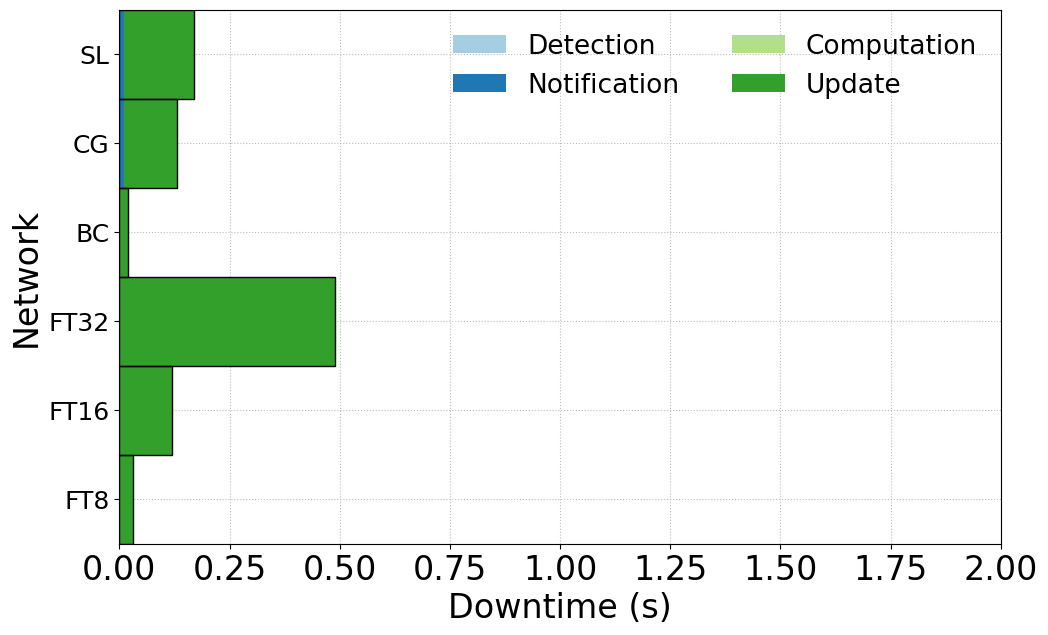

In [115]:
print("# Downtime Factors Cost Breakdown -- PC-SDN")

# dtd = "100us"
dtd = "1ms"
# dtd = "10ms"
# dtd = "100ms"

# cld = "10ms"
cld = "0ns"

# eid = "100us"
eid = "1ms"
# eid = "10ms"

ppd = "10ns"

display(tab_cb_pcsdn[dtd][cld][eid][ppd])

# fig = pylab.figure(figsize=[2.5*x for x in [8.80, 2.75]])
fig = pylab.figure()

baridx = np.arange(len(all_topos))

barvalsum = np.zeros(len(all_topos))
for i, c in enumerate(columns_cb_pcsdn):
    barval = tab_cb_pcsdn[dtd][cld][eid][ppd][c]
    pylab.barh(y=baridx, width=barval, height=1, left=barvalsum, align="center", label=collbls_cb_pcsdn[i], color=colors_cb[i])
    barvalsum = barvalsum + barval
pylab.barh(baridx, width=barvalsum, height=1, align="center", edgecolor='k', color='#00000000')

# pylab.legend(fontsize=20)  #, loc="lower left")
pylab.legend(fontsize=19, ncol=2, frameon=False)  #, loc="upper left")
pylab.xlabel(f"Downtime ({sms})")
pylab.ylabel('Network')
# pylab.xticks(range(0, 100 + 1, 10), fontsize=18)
pylab.yticks(baridx, [ns[x] for x in all_topos], fontsize=18)
pylab.xlim(0, 2)
# pylab.xscale("log")
pylab.ylim(-0.5, 5.5)

ax1 = fig.gca()
ax1.set_axisbelow(True)
ax1.grid(ls=':', axis='both', which='both', c=gridcolor)

pylab.tight_layout()
if save_figs:
    # pylab.savefig(f"./results/downtime/figures/ab_breakdown_pcsdn.pdf", bbox_inches='tight')
    pass

### Felix

# Downtime Factors Cost Breakdown -- Felix


,detection,coordination
FatTree8,0.0,0.00
FatTree16,0.0,0.00
FatTree32,0.0,0.00
Bellcanada,0.0,0.00
Cogentco,0.0,0.01
rf1239_real_hard,0.0,0.03


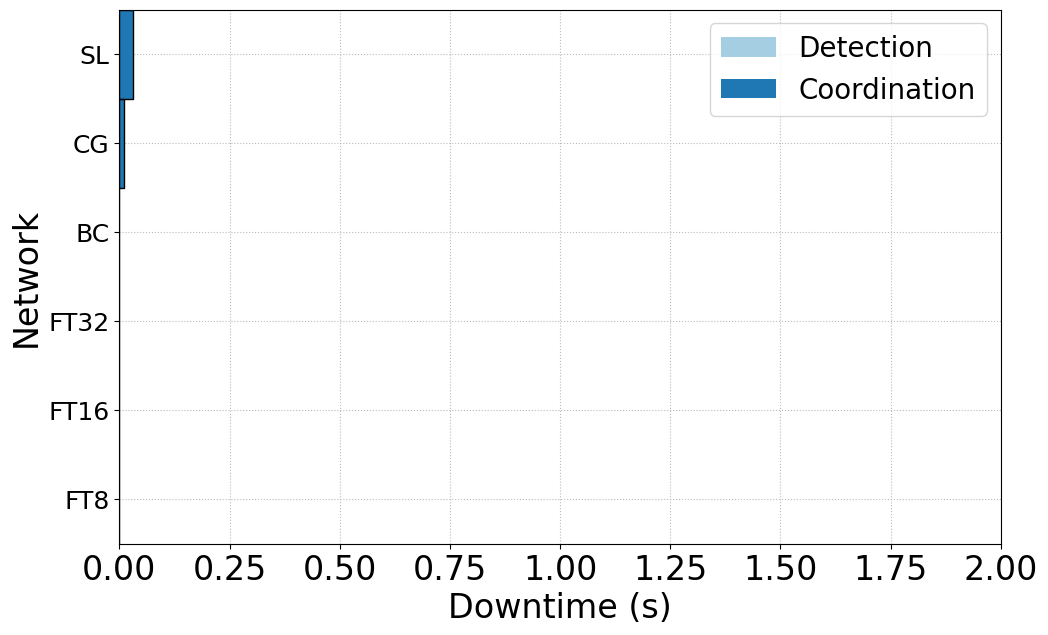

In [116]:
print("# Downtime Factors Cost Breakdown -- Felix")

# dtd = "100us"
dtd = "1ms"
# dtd = "10ms"
# dtd = "100ms"

# cld = "10ms"
cld = "0ns"

# eid = "100us"
eid = "1ms"
# eid = "10ms"

ppd = "10ns"

display(tab_cb_felix[dtd][cld][eid][ppd])

# fig = pylab.figure(figsize=[2.5*x for x in [8.80, 2.75]])
fig = pylab.figure()

baridx = np.arange(len(all_topos))

barvalsum = np.zeros(len(all_topos))
for i, c in enumerate(columns_cb_felix):
    barval = tab_cb_felix[dtd][cld][eid][ppd][c]
    pylab.barh(y=baridx, width=barval, height=1, left=barvalsum, align="center", label=collbls_cb_felix[i], color=colors_cb[i])
    barvalsum = barvalsum + barval
pylab.barh(baridx, width=barvalsum, height=1, align="center", edgecolor='k', color='#00000000')

pylab.legend(fontsize=20)  #, loc="lower left")
pylab.xlabel(f"Downtime ({sms})")
pylab.ylabel('Network')
# pylab.xticks(range(0, 100 + 1, 10), fontsize=18)
pylab.yticks(baridx, [ns[x] for x in all_topos], fontsize=18)
pylab.xlim(0, 2)
# pylab.xscale("log")
pylab.ylim(-0.5, 5.5)

ax1 = fig.gca()
ax1.set_axisbelow(True)
ax1.grid(ls=':', axis='both', which='both', c=gridcolor)

pylab.tight_layout()
if save_figs:
    # pylab.savefig(f"./results/downtime/figures/ab_breakdown_felix.pdf", bbox_inches='tight')
    pass

### All Approaches

# Downtime Factors Cost Breakdown -- All Approaches


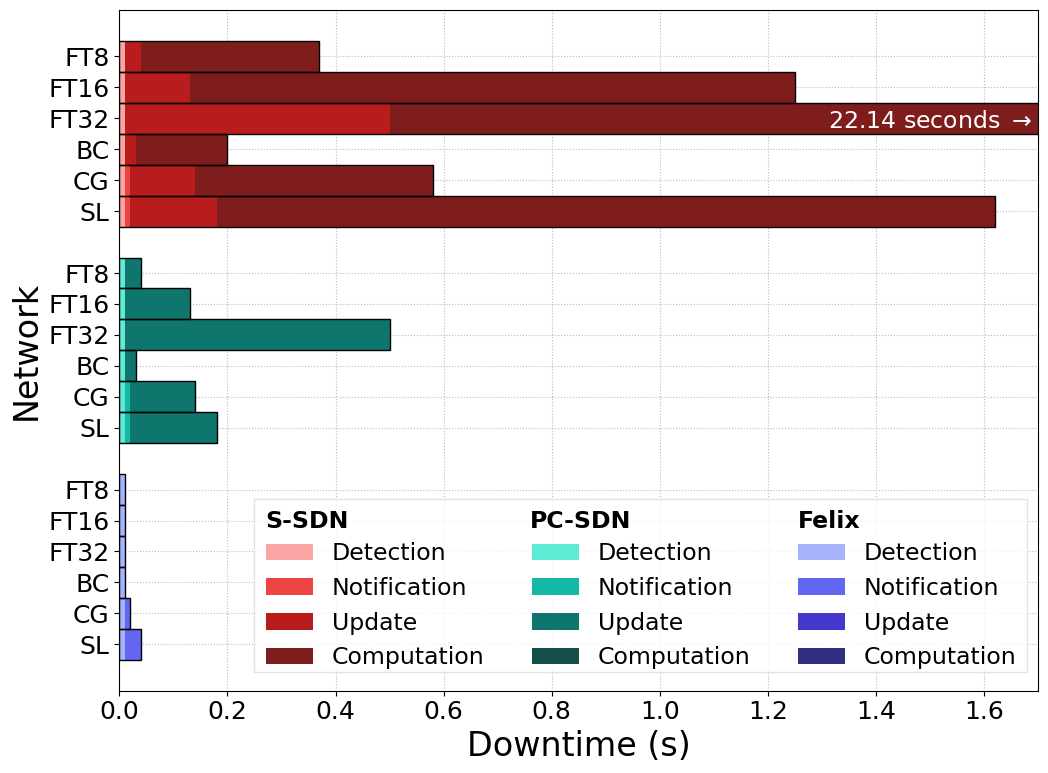

In [117]:
print("# Downtime Factors Cost Breakdown -- All Approaches")
ltfs = 17

columns_cb_ssdn = ["detection", "notification", "update", "computation"]
collbls_cb_ssdn = [x.title() for x in columns_cb_ssdn]
colors_cb_ssdn = ["#FCA5A5", "#EF4444", "#B91C1C", "#7F1D1D"]

columns_cb_pcsdn = ["detection", "notification", "update", "computation"]
collbls_cb_pcsdn = [x.title() for x in columns_cb_pcsdn]
colors_cb_pcsdn  = ["#5EEAD4", "#14B8A6", "#0F766E", "#134E4A"]

columns_cb_felix = ["detection", "coordination", "update", "computation"]
zero_cb_felix = ["update", "computation"]
collbls_cb_felix = [x.title() for x in columns_cb_ssdn]
colors_cb_felix = ["#A5B4FC", "#6366F1", "#4338CA", "#312E81"]

# dtd = "100us"
# dtd = "1ms"
dtd = "10ms"
# dtd = "100ms"

# cld = "10ms"
cld = "0ns"

# eid = "100us"
eid = "1ms"
# eid = "10ms"

ppd = "10ns"

# display(tab_cb_ssdn[dtd][cld][eid][ppd])

# fig = pylab.figure(figsize=[2.5*x for x in [8.80, 2.75]])
# fig = pylab.figure(figsize=[2.5*x for x in [4.40, 4.40]])
fig = pylab.figure(figsize=[2.5*x for x in [4.40, 3.30]])
ax1 = fig.gca()

baridx_ssdn = list(reversed(np.arange(len(all_topos)) + 2*(len(all_topos) + 1)))
barvalsum = np.zeros(len(all_topos))
for i, c in enumerate(columns_cb_ssdn):
    barval = tab_cb_ssdn[dtd][cld][eid][ppd][c]
    pylab.barh(y=baridx_ssdn, width=barval, height=1, left=barvalsum, align="center", label=collbls_cb_ssdn[i], color=colors_cb_ssdn[i])
    barvalsum = barvalsum + barval
pylab.barh(baridx_ssdn, width=barvalsum, height=1, align="center", edgecolor='k', color='#00000000')

baridx_pcsdn = list(reversed(np.arange(len(all_topos)) + len(all_topos) + 1))
barvalsum = np.zeros(len(all_topos))
for i, c in enumerate(columns_cb_pcsdn):
    barval = tab_cb_pcsdn[dtd][cld][eid][ppd][c]
    pylab.barh(y=baridx_pcsdn, width=barval, height=1, left=barvalsum, align="center", label=collbls_cb_pcsdn[i], color=colors_cb_pcsdn[i])
    barvalsum = barvalsum + barval
pylab.barh(baridx_pcsdn, width=barvalsum, height=1, align="center", edgecolor='k', color='#00000000')

baridx_felix = list(reversed(np.arange(len(all_topos))))
barvalsum = np.zeros(len(all_topos))
for i, c in enumerate(columns_cb_felix):
    if c in zero_cb_felix:
        pylab.barh(y=baridx_felix, width=np.zeros(len(baridx_felix)), height=1, left=barvalsum, align="center", label=collbls_cb_felix[i], color=colors_cb_felix[i])
    else:
        barval = tab_cb_felix[dtd][cld][eid][ppd][c]
        pylab.barh(y=baridx_felix, width=barval, height=1, left=barvalsum, align="center", label=collbls_cb_felix[i], color=colors_cb_felix[i])
        barvalsum = barvalsum + barval
pylab.barh(baridx_felix, width=barvalsum, height=1, align="center", edgecolor='k', color='#00000000')

# pylab.legend(fontsize=20)  #, loc="lower left")
pylab.legend(fontsize=17, ncol=3, frameon=False)  #, loc="upper left")
pylab.xlabel(f"Downtime ({sms})")
pylab.ylabel('Network')
pylab.yticks(baridx_ssdn + baridx_pcsdn + baridx_felix, [ns[x] for x in all_topos + all_topos + all_topos], fontsize=18)

if sms == "s":
    pylab.xlim(0, 1.7)
elif sms == "ms":
    pylab.xlim(0, 1700)


if sms == "s":
    pylab.xticks(np.arange(0, 1.8, 0.2), fontsize=18)
    pylab.text(x=1.69, y=16.9, s="22.14 seconds $\\rightarrow$", fontsize=17, ha="right", va="center", color="w")
    pylab.text(x=0.27, y=3.75, s="S-SDN", fontsize=ltfs, weight="bold")
    pylab.text(x=0.76, y=3.75, s="PC-SDN", fontsize=ltfs, weight="bold")
    pylab.text(x=1.255, y=3.75, s="Felix", fontsize=ltfs, weight="bold")
    rec = Rectangle(xy=(0.25, -0.9), width=1.43, height=5.6, fc="w", ec="#dddddd", alpha=0.8)
    ax1.add_patch(rec)
elif sms == "ms":
    pylab.xticks(np.arange(0, 1800, 200), fontsize=18)
    pylab.text(x=1690, y=16.9, s="~22000 ms $\\rightarrow$", fontsize=17, ha="right", va="center", color="w")
    pylab.text(x=270, y=5, s="S-SDN", fontsize=ltfs, weight="bold")
    pylab.text(x=760, y=5, s="PC-SDN", fontsize=ltfs, weight="bold")
    pylab.text(x=1255, y=5, s="Felix", fontsize=ltfs, weight="bold")
    rec = Rectangle(xy=(250, -0.9), width=1430, height=7.2, fc="w", ec="#dddddd", alpha=0.8)
    ax1.add_patch(rec)

ax1.set_axisbelow(True)
ax1.grid(ls=':', axis='both', which='both', c=gridcolor)

pylab.tight_layout()
if save_figs:
    pylab.savefig(f"./results/downtime/figures/fig7-downtime-factor-cost-breakdown.pdf", bbox_inches='tight')
    pass